In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
import math
import random
import cvxopt
from cvxopt import matrix, solvers
import pypfopt
from scipy.optimize import minimize
%matplotlib inline

In [2]:
tickers_list = ['TSLA','LAC',
                'AMZN', 'NFLX',
                'WMT', 'COST',
               'FL', 'RILY',
               'ENPH', 'SHOP',
               'PLUG', 'SEDG',
               'ETSY', 'MRTX',
               'TJX', 'NKE',
               'AAPL', 'FB',
               'GOOG', 'NVDA']

df = yf.download(tickers_list,'2017-01-01', '2020-12-31')['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [3]:
'''
This cell computes the number of missing values in the datframe
'''
stocks = []
nans = []
for i in df.columns:
    stocks.append(i)
    count_nan = df[str(i)].isna().sum()
    nans.append(count_nan)

nan_df = pd.DataFrame(stocks)
nan_df['nans'] = nans
nan_df.columns = ['stock', 'nan values']

In [5]:
#calculate the daily returns of each stock
daily_returns = df.pct_change()
daily_returns = daily_returns.iloc[1:,:]

In [6]:
#get average daily returns
mean_daily_returns = daily_returns.values.mean(axis=0)

In [7]:
#Normalise daily returns and calculate covariance matrix, eigen values and eigen vectors
Y = daily_returns.values - mean_daily_returns
cov = np.cov(Y.T)
eigen_values, eigen_vectors = np.linalg.eig(cov)

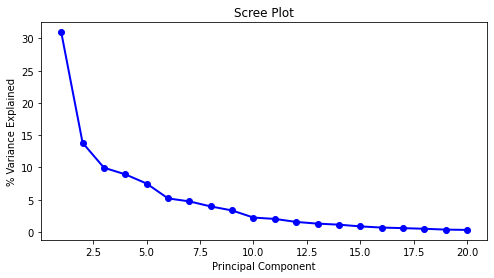

90.66084113219185


In [8]:
#Scree plot
x = eigen_values
w = []
z = []
cnt = 1
for i in x:
    w.append(100*(i/sum(x)))
    z.append(cnt)
    cnt+=1
    
w = sorted(w, key=float, reverse=True)
plt.rcParams["figure.figsize"] = (8, 4)
plt.plot(z, w,'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')
plt.show()

x=0
for i in range(0,10):
    x += w[i]
    
print(x)

In [9]:
#calculate factor loadings
factor_loading = pd.DataFrame(eigen_vectors)
factor_loading.columns = ['FL1', 'FL2', 'FL3', 'FL4', 'FL5', 'FL6','FL7', 'FL8', 'FL9', 'FL10', 'FL11', 'FL12',
                   'FL13', 'FL14', 'FL15', 'FL16','FL17', 'FL18', 'FL19', 'FL20']
factor_loading.index = daily_returns.columns
factor_loading

,FL1,FL2,FL3,FL4,FL5,FL6,FL7,FL8,FL9,FL10,FL11,FL12,FL13,FL14,FL15,FL16,FL17,FL18,FL19,FL20
AAPL,-0.157434,0.037101,-0.033142,0.123124,0.097285,-0.050405,-0.000809,0.005175,-0.153352,0.117257,0.104534,0.025558,-0.295318,0.118022,0.194993,0.037133,0.079894,0.263665,-0.622592,0.540958
AMZN,-0.137060,0.042950,-0.040636,0.130783,0.153072,0.043687,-0.045560,-0.002029,-0.160744,0.042854,0.167557,-0.205696,-0.038979,0.162604,0.243825,0.061014,0.427521,0.168798,-0.200980,-0.701670
COST,-0.075665,0.012301,-0.028311,0.066061,0.051263,-0.071270,-0.024904,-0.015830,-0.064947,0.038788,0.066166,-0.021476,-0.306352,-0.287752,0.357187,-0.788560,-0.117872,-0.067014,0.151786,-0.048293
ENPH,-0.447316,0.083194,0.693749,-0.419248,-0.044493,0.062221,-0.010896,-0.327451,-0.109760,-0.022574,0.088513,0.040781,0.002139,0.005288,0.009405,0.004306,-0.012468,-0.001712,0.018753,-0.005712
ETSY,-0.226851,0.093774,0.025293,0.166449,0.297141,0.056148,-0.477129,-0.076953,0.713427,0.265512,0.044275,0.048537,0.033908,0.018531,0.001374,0.009497,-0.011141,-0.000011,0.023190,0.018536
FB,-0.143318,0.045517,-0.046634,0.154599,0.118900,-0.027950,-0.036279,-0.010869,-0.228308,0.129227,0.102064,-0.132351,-0.189717,0.626228,-0.140757,-0.073061,0.201669,-0.267254,0.464893,0.238067
FL,-0.122953,0.064836,-0.059945,0.141421,-0.149681,-0.741056,0.079006,-0.257832,0.185606,-0.360548,0.128505,-0.120192,0.259860,0.114236,0.176254,0.001288,0.004021,-0.054500,-0.025401,0.046031
GOOG,-0.128530,0.041582,-0.046962,0.130503,0.099828,-0.069701,-0.015069,-0.011646,-0.163594,0.099675,0.067664,-0.070909,-0.149008,0.209906,-0.002143,0.175169,-0.851346,0.003517,-0.072031,-0.272176
LAC,-0.287961,0.150269,-0.142663,0.283977,-0.811983,0.291476,-0.209844,-0.045631,-0.007213,0.003284,0.044661,0.001579,0.004504,-0.003529,0.018688,0.001801,-0.008199,0.020826,0.012015,-0.004383
MRTX,-0.353354,-0.922144,-0.113022,-0.043163,-0.048876,-0.002747,0.011490,0.040953,0.061532,-0.008402,-0.021622,-0.026496,0.001054,0.026434,-0.009141,-0.004825,-0.001927,0.003153,-0.002723,-0.009791


In [10]:
#Determine highest contributer to each factor
m = []
for i in factor_loading.columns:
    a = min((factor_loading[i]))
    b = max(factor_loading[i])
    
    if abs(a) > abs(b):
        y =factor_loading[i].to_list()
        y = y.index(a)
        m.append(daily_returns.columns[y])
    else:
        y =factor_loading[i].to_list()
        y = y.index(b)
        m.append(daily_returns.columns[y])

print(m)

['ENPH', 'MRTX', 'ENPH', 'PLUG', 'LAC', 'FL', 'TSLA', 'SEDG', 'ETSY', 'SHOP', 'RILY', 'NVDA', 'NVDA', 'FB', 'TJX', 'COST', 'GOOG', 'NKE', 'AAPL', 'AMZN']


In [11]:
#determine the factors to be used 
factors = np.matmul(Y , eigen_vectors)
factors = pd.DataFrame(factors)
factors = factors.iloc[:,0:10]
factors.columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6','F7', 'F8', 'F9', 'F10']
factors

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
0,-0.139651,-0.001610,0.025131,-0.056835,0.009541,-0.017230,0.037035,0.038225,0.006450,-0.017337
1,-0.016739,-0.067700,-0.021603,0.060886,0.028109,0.044752,-0.046077,-0.024817,0.005329,-0.033739
2,0.010256,0.036006,0.000154,0.027712,0.038346,-0.005732,-0.014602,-0.009234,0.017610,0.053444
3,-0.004618,0.035932,-0.023708,0.036720,-0.085675,0.032099,0.008806,-0.016826,-0.058510,-0.012562
4,0.000759,0.023239,0.019683,0.008631,-0.005117,0.002983,-0.026590,-0.008549,0.021018,0.002046
...,...,...,...,...,...,...,...,...,...,...
1000,-0.001451,0.018975,-0.007651,-0.007418,-0.119132,-0.011308,0.020154,-0.017598,-0.008295,0.035542
1001,0.006958,0.008557,0.013634,0.016637,0.017363,0.014021,0.015415,-0.004951,-0.004964,0.003695
1002,0.063440,0.017820,0.001874,0.058224,-0.023778,-0.049439,0.041898,-0.020269,-0.067823,0.052037
1003,0.057848,0.001403,-0.003217,0.032939,0.038253,0.007211,0.003393,-0.017539,-0.011897,-0.016355


In [12]:
#Minimise for volatility and calculate the optimal weighting of each factor
daily_factor_returns = factors.mean() 
daily_factor_returns
annual_factor_returns = daily_factor_returns*252
cov = factors.cov()*252 

In [13]:
volatility_constraint = 0.30

def solve_for_max_returns(p):
    p = np.array(p)
    R = np.sum(annual_factor_returns*p)
    return -1*R

def weights_check(p):
    return np.sum(p)-1

def volatility(p):
    p = np.array(p)
    V = np.sqrt(np.dot(p.T,np.dot(cov,p))) 
    return V

#inital weights, bounds and constraints
p0 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
constraints = ({'type':'eq', 'fun':weights_check},
                {'type':'eq', 'fun': lambda p: volatility(p) - volatility_constraint})
#solve for the optimal factor weightings
p_opt = minimize(solve_for_max_returns, p0, method = 'SLSQP', bounds = bounds, constraints=constraints)
p_opt_weightings = p_opt.x
p_volatility = volatility(p_opt_weightings)*100

array([0.17666822, 0.11870784, 0.10438629, 0.10049911, 0.09502665,
       0.08611178, 0.08430292, 0.08121154, 0.07874461, 0.07434105])

In [14]:
factor_weights = []
for i in p_opt.x:
    factor_weights.append(i)   
factor_weights

[0.17666821620087378,
 0.118707839131711,
 0.10438628981326468,
 0.10049910672384255,
 0.09502664963090482,
 0.08611178047890977,
 0.08430292124572936,
 0.08121153590360322,
 0.07874460968307984,
 0.07434105118808107]

In [15]:
#Determine the optimal portfolio
mean_annual_returns = mean_daily_returns*252

factor_loading = pd.DataFrame(eigen_vectors)
factor_loading = factor_loading.iloc[:,0:10]
factor_loading = abs(factor_loading)
factor_loading = factor_loading/factor_loading.sum(axis=0) #weighting of each stock in each factor

mean_annual_returns = mean_daily_returns*252


portfolio_weights = np.matmul(factor_loading,factor_weights)
portfolio_weights

portfolio_stock_returns = portfolio_weights*mean_annual_returns
portfolio_stock_returns

portfolio_annual_return = round(sum(100*portfolio_stock_returns),2)

print(f"Annual Portfolio Return: {portfolio_annual_return}%")
print(f"Portfolio Volatility: {np.round(p_volatility,)}%")

Annual Portfolio Return: 77.0%
Portfolio Volatility: 30.0%


In [16]:
# portfolio_weights = pd.DataFrame(portfolio_weights)
# portfolio_weights.columns = ['Weight']
# portfolio_weights.index = daily_returns.columns
# print(portfolio_weights.to_latex())

In [17]:
# Get Market Benchmark
tickers_list = ['TSLA','LAC',
                'AMZN', 'NFLX',
                'WMT', 'COST',
               'FL', 'RILY',
               'ENPH', 'SHOP',
               'PLUG', 'SEDG',
               'ETSY', 'MRTX',
               'TJX', 'NKE',
               'AAPL', 'FB',
               'GOOG', 'NVDA']

df = yf.download(tickers_list,'2021-01-01', '2021-06-30')['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [18]:
#optimal portfolio
portfolio_weights 

#cap weighted portfolio
cap = [2.57, 1.78, 0.24129, 0.03338, 0.033688, 0.92666, 0.00506, 1.89, 0.00429, 0.00755, 0.29485, 0.26594, 0.78758, 0.02320, 0.00215, 0.01793, 0.19799, 0.08341, 1.09, 0.40405]

cap_weights = []
for i in cap:
    cap_weights.append(i/sum(cap))

In [19]:
#calculate the daily returns of each stock
daily_returns = df.pct_change()
daily_returns = daily_returns.iloc[1:,:]
mean_period_returns = daily_returns.values.mean(axis=0)*len(df.index)
mean_period_returns

portfolio_stock_returns = portfolio_weights*mean_period_returns

cap_stock_returns = cap_weights*mean_period_returns

portfolio_period_return = round(sum(100*portfolio_stock_returns),2)
cap_period_return = round(sum(100*cap_stock_returns),2)

print(f"Period Portfolio Return: {portfolio_period_return}%")
print(f"Period Market Return: {cap_period_return}%")

Period Portfolio Return: 20.21%
Period Market Return: 16.98%


In [20]:
#Calculate Variance
Y = daily_returns.values - daily_returns.values.mean(axis =0)
cov = np.cov(Y.T)
cap_weights = pd.Series(cap_weights)

opt_variance = round(100*np.dot(portfolio_weights.T,np.dot(cov,portfolio_weights))*len(df.index),2)
cap_variance = round(100*np.dot(cap_weights.T,np.dot(cov,cap_weights))*len(df.index),2)

# opt_variance =np.dot(portfolio_weights.T,np.dot(cov,portfolio_weights))*len(df.index)
# cap_variance = np.dot(cap_weights.T,np.dot(cov,cap_weights))*len(df.index)


print(f"Period Portfolio Variance: {opt_variance}%")
print(f"Period Market Variance: {cap_variance}%")

Period Portfolio Variance: 7.36%
Period Market Variance: 2.89%
